In [1]:
from custom_functions import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def f1(x_arr, b, g):
    #x_arr is an array where x_arr[0] = x and x_arr[1] = z

    dxdt = x_arr[0] - (x_arr[0]**2)*np.exp(-b*x_arr[0]*x_arr[1])
    dzdt = x_arr[1] - (x_arr[1]**2)*np.exp(-g*x_arr[0])

    return np.array([dxdt, dzdt])


def df(x):
    h = 1e-06
    J = MyJacobian(function_being_used, x, h)
    if J.ndim > 2:
        J = J.squeeze(axis=2)
    return J

def function_for_IVP(t, x):
    b = 1
    g = -1
    return f1(x, b, g)

## Eqlib points for g = -1, b = 1 is (1.4108, 0.2439)

## Now to track the euqlib, 
need to set up a RHS

## userf1 is without extra dims

In [3]:
def userf(x_arr):
    #g is included in x_arr
    #x_arr is an array where x_arr[0] = x and x_arr[1] = z, x_arr[2] = g
    b = 1
    dxdt = x_arr[0] - (x_arr[0]**2)*np.exp(-b*x_arr[0]*x_arr[1])
    dzdt = x_arr[1] - (x_arr[1]**2)*np.exp(-x_arr[2]*x_arr[0])

    return np.array([dxdt, dzdt])

def userdf(x):
    h = 1e-06
    J = MyJacobian(userf, x, h)
    if J.ndim > 2:
        J = J.squeeze(axis=2)
    return J

In [4]:
def userf1(t, x_arr, p):
    '''2D ODE system for the AMOC
    Input
    t  : float
        time value
    x  : array (2, N)
        state space values
    p  : array (2,)
        parameter values
    
    
    Returns
    xout: array, shape (2, N)
           Array containing derivative at x
           2nd dimension denotes derivatives for different points
    '''
    
    if x_arr.ndim == 1:
        x_arr = np.expand_dims(x_arr, axis=1)
    
    n = x_arr.shape
    xout = np.empty(n)
    xout[:] = np.nan 

    b = p[0,]
    g = p[1,]
    
    
    b = 1
    xout[0,:] = x_arr[0, :] - (x_arr[0, :]**2)*np.exp(-b*x_arr[0, :]*x_arr[1, :])
    xout[1,:] = x_arr[1, :] - (x_arr[1, :]**2)*np.exp(-g*x_arr[0, :])
    return xout

# Find Eq with b = 1, g = -1

[1.41080616 0.24394654]


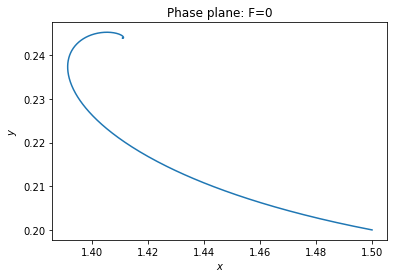

In [5]:
# Define parameters p
b = 1
g = -1
p = np.array([b, g])

#define variable to go into MyIVP
x0 = np.array([1.5,0.2])
tspan = [0,100]
h = 0.01

#call MyIVP
[X,t,xeq1] = MyIVP(lambda t,x:userf1(t,x,p),x0,tspan,h)
X = np.squeeze(X)
xeq1 = np.squeeze(xeq1)
print(xeq1)

#Plot
plt.plot(X[0,:],X[1,:])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Phase plane: F=0")

plt.show()

# Now Track the Equilibria

In [25]:
# Define RHS for tracking equilibria
RHS = lambda y: userf1(0,y[0:2,:],np.array([b, y[2,:]]))

h=1e-6
df= lambda y: np.squeeze(MyJacobian(RHS,y,h),axis=2)

# Define MyTrackCurve initial points, MAKE GUESS OF Y TANGENT
y0 = np.append(xeq1,np.array([g]),axis=0);
ytan0 = np.expand_dims(np.array([0,0,1]),axis=1); # guess in the direction of increasing F

# Solve for the true initial tangent
df0 = df(y0)
zeros0 = np.zeros((2,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

print(ytan)

ylist1 = MyTrackCurve(RHS,df,y0,ytan,nmax=5000,stepsize=0.005)


#NOW OTHER DIRECTION
# guess in direction for decreasing F
ytan0 = np.expand_dims(np.array([0,0,-1]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist2 = MyTrackCurve(RHS,df,y0,ytan,nmax=2000,stepsize=0.005)

C:\Users\aaron\AppData\Local\Temp\ipykernel_1036\3225258700.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS = lambda y: userf1(0,y[0:2,:],np.array([b, y[2,:]]))


[0.50735311 0.16717552 0.84536689]


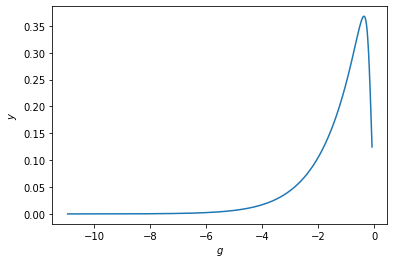

In [7]:
ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1);

plt.plot(ylist[2,:],ylist[1,:])
plt.xlabel("$g$")
plt.ylabel("$y$")

plt.show()

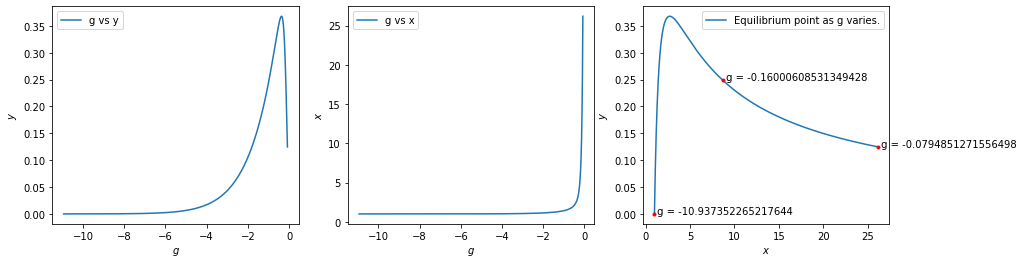

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axs[0]
ax1.plot(ylist[2,:],ylist[1,:], label = 'g vs y')
ax1.set_xlabel("$g$")
ax1.set_ylabel("$y$")
ax1.legend()
ax1.set_title("")

ax2 = axs[1]
ax2.plot(ylist[2,:], ylist[0,:], label = 'g vs x')
ax2.set_xlabel("$g$")
ax2.set_ylabel("$x$")
ax2.legend()
ax2.set_title("")

ax3 = axs[2]
length = ylist.shape[1] # The number of points in ylist
ax3.plot(ylist[0,:], ylist[1,:], label = 'Equilibrium point as g varies.')
label = ' g = ' + str(ylist[2,0])
ax3.plot(ylist[0,0], ylist[1,0], '.', color = 'r')
ax3.text(ylist[0,0], ylist[1,0],label)

label = ' g = ' + str(ylist[2,int(length/2)])
ax3.plot(ylist[0,int(length/2)], ylist[1,int(length/2)], '.', color = 'r' )
ax3.text(ylist[0,int(length/2)], ylist[1,int(length/2)],label)

label = ' g = ' + str(ylist[2,length-1])
ax3.plot(ylist[0,int(length-1)], ylist[1,int(length-1)], '.', color = 'r' )
ax3.text(ylist[0,int(length-1)], ylist[1,int(length-1)],label)

ax3.set_xlabel("$x$")
ax3.set_ylabel("$y$")
ax3.legend()
ax3.set_title("")

#ax4 = axs[1, 1]

plt.show()

### Find stability at each point

In [9]:
#Finding the eigen values (eig_val), and stability (stab) at at value of g
stab = np.empty((ylist.shape[1],1))*np.nan
#note that the number of eigen values at each point of g will be ylist's (=[x,z,g])  width-1
eig_val = np.empty((ylist.shape[1],ylist.shape[0]-1))*np.nan


for i in np.arange(0,ylist.shape[1]):
    p_i =np.array([b, ylist[2,i]])
    J = MyJacobian(lambda x:userf1(0,x,p_i),ylist[0:2,i],h)
    eig_val[i] = np.real(linalg.eig(J[:,:,0])[0])
    max_eig = max(eig_val[i])
    stab[i] = max_eig > 0
    if (i>0 and stab[i] != stab[i-1] and stab[i-1] != 10):
        #print(max_eig)
        stab[i] = 10


C:\Users\aaron\AppData\Local\Temp\ipykernel_1036\1301342527.py:4: RuntimeWarning: invalid value encountered in multiply
  eig_val = np.empty((ylist.shape[1],ylist.shape[0]-1))*np.nan


### Plot stabilities

7.391470266823781 0.2706263566684276 -0.17682762968161514


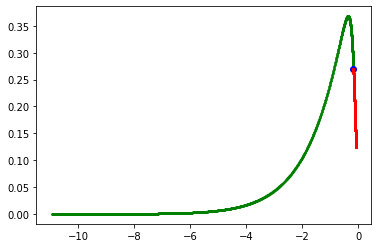

In [10]:
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        plt.plot(ylist[2,i],ylist[1,i],'g.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        plt.plot(ylist[2,i],ylist[1,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        plt.plot(ylist[2,i],ylist[1,i],marker='o',color='b',markersize=6,label='SN')
        print(ylist[0,i],ylist[1,i], ylist[2,i])
    else:
        print('Error - undefined stability type')

# 2 Parameter Track (in b and g)
The change in stability found above was likely a hopf Bif

In [11]:
#Define functions
def df_2param(y):
    J = MyJacobian(lambda x:userf1(0,x,np.array([y[2],y[3]])),y[0:2],h)
    J = np.squeeze(J,axis=2)
    return J

######### Fold Bif ############

RHS_fold = lambda y: np.append(userf1(0,y[0:2,:],np.array([y[2,:],y[3,:]])),
                               np.expand_dims(np.array([linalg.det(df_2param(y))]),axis=1),axis=0)

df_fold= lambda y: np.squeeze(MyJacobian(RHS_fold,y,h),axis=2)

######### Hopf Bif ############

RHS_hopf = lambda y: np.append(userf1(0,y[0:2,:],np.array([y[2,:],y[3,:]])),
                               np.expand_dims(np.array([np.trace(df_2param(y))]),axis=1),axis=0)

df_hopf= lambda y: np.squeeze(MyJacobian(RHS_hopf,y,h),axis=2)

### Track Curve

In [26]:
#RHS_used and df_used is either RHS_fold or RHS_hopf
RHS_used = RHS_hopf
df_used = df_hopf


# Define MyTrackCurve initial points
f_inds = np.where(stab == 10)[0]
y0 = np.array([ylist[0,f_inds[0]], ylist[1,f_inds[0]], ylist[2,f_inds[0]], b])
print(y0)

ytan0 = np.expand_dims(np.array([0,0,0,1]),axis=1) # guess i the direction of increasing params

# Solve for the true initial tangent
df0 = np.squeeze(df_used(y0))
zeros0 = np.zeros((3,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult
print(ytan)

yused1 = MyTrackCurve(RHS_used,df_used,y0,ytan,stepsize=0.01,nmax=200)

# guess in direction for decreasing params
ytan0 = np.expand_dims(np.array([0,0,-1,0]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yused2 = MyTrackCurve(RHS_used,df_used,y0,ytan,stepsize=0.01,nmax=200)

[ 7.39147027  0.27062636 -0.17682763  1.        ]
[-1.74523896e-02  3.19111500e-04  0.00000000e+00  9.99847645e-01]


LinAlgError: Singular matrix

[[ 7.39147027  7.3890561   7.3890561   7.3890561   7.38905609  7.3890561
   7.38905609  7.3890561   7.3890561   7.38905611  7.38905609  7.38905611
   7.3890561   7.3890561   7.3890561   7.38905609  7.3890561   7.3890561
   7.3890561   7.38905609  7.38905609  7.38905609  7.3890561   7.3890561
   7.3890561   7.38905609  7.3890561   7.3890561   7.3890561   7.38905609
   7.38905609  7.3890561   7.3890561   7.38905609  7.3890561   7.38905609
   7.3890561   7.38905609  7.3890561   7.3890561   7.38905609  7.3890561
   7.3890561   7.38905609  7.3890561   7.3890561   7.3890561   7.38905611
   7.38905609  7.3890561   7.3890561   7.38905609  7.3890561   7.38905609
   7.3890561   7.38905611  7.3890561   7.38905609  7.3890561   7.3890561
   7.38905609  7.3890561   7.3890561   7.3890561   7.3890561   7.38905611
   7.3890561   7.3890561   7.3890561   7.3890561   7.3890561   7.3890561
   7.3890561   7.38905609  7.3890561   7.38905611  7.38905609  7.3890561
   7.38905611  7.3890561   7.38905609  7.3890

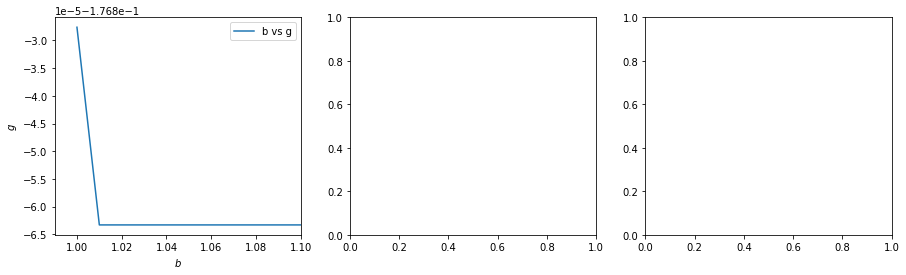

In [23]:
yused = np.concatenate((np.flip(yused2,1),yused1),axis=1);
print(yused1)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axs[0]
ax1.plot(yused1[2,:],yused1[3,:], label = 'b vs g')
#ax1.plot(yused1[:,2],yused1[:,3], label = 'b vs g')
ax1.set_xlabel("$b$")
ax1.set_ylabel("$g$")
ax1.set_xlim(0.99,1.1)
ax1.legend()
ax1.set_title("")

#plt.axis([0.7,1.3,0,100])

plt.show()